<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch05_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 05 — Support Vector Machines (SVM)

## 1) Summary
This chapter covers Support Vector Machines for:
- Linear SVM classification (large margin, support vectors)
- Soft-margin classification and the role of `C`
- Nonlinear SVM: polynomial features, polynomial kernel, RBF (Gaussian) kernel
- Hyperparameters: `C`, `degree`, `coef0`, `gamma`
- SVM regression (LinearSVR and SVR)

## 2) Learning Goals
- Understand the idea of maximizing the margin and why support vectors matter.
- Know how soft margin works and how `C` controls bias–variance.
- Use kernels (poly, RBF) for nonlinear decision boundaries.
- Understand how `gamma` affects RBF flexibility.
- Apply SVMs to regression and interpret the epsilon-insensitive tube.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    # Works for linear SVM with coef_ and intercept_.
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -(w[0] * x0 + b) / w[1]

    margin = 1 / np.linalg.norm(w)
    gutter_up = decision_boundary + margin / w[1]
    gutter_down = decision_boundary - margin / w[1]

    plt.plot(x0, decision_boundary, "k-")
    plt.plot(x0, gutter_up, "k--")
    plt.plot(x0, gutter_down, "k--")

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 200)
    x1s = np.linspace(axes[2], axes[3], 200)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, alpha=0.2)
    plt.contour(x0, x1, y_pred, colors="k", linewidths=0.5)

# Part A — Linear SVM Classification (Iris)

## 3) Linear SVM Classification on Iris (Binary)

We use Iris features:
- petal length (cm)
- petal width (cm)

Binary target:
- 1 = Virginica
- 0 = Not Virginica

Key idea: SVM tries to find a decision boundary that maximizes the margin.
Only a few training instances (support vectors) define the boundary.

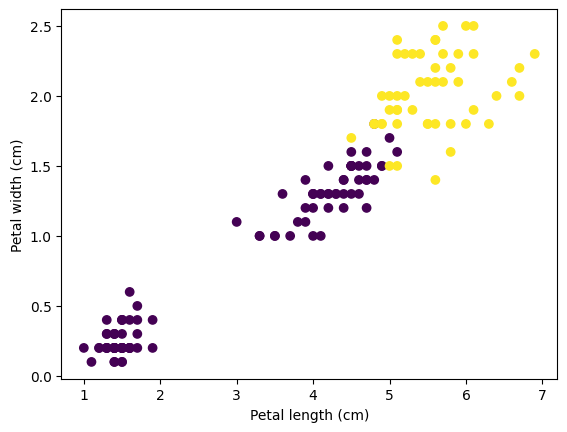

In [3]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Virginica?

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.show()

## 4) Linear SVM with Feature Scaling (Recommended)

SVMs are sensitive to feature scales.
We use a pipeline: StandardScaler + LinearSVC.

`C` controls regularization:
- smaller C -> wider margin, more violations allowed (more regularization)
- larger C -> tries harder to fit training data (less regularization)

In [4]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1.0, loss="hinge", random_state=42, max_iter=20000))
])

svm_clf.fit(X, y)
svm_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(loss='hinge', max_iter=20000, random_state=42))])

## 5) Visualize the Linear Decision Boundary

We plot the decision boundary and margins.
For plotting, we access the trained LinearSVC inside the pipeline and convert
coefficients back to the original feature scale.

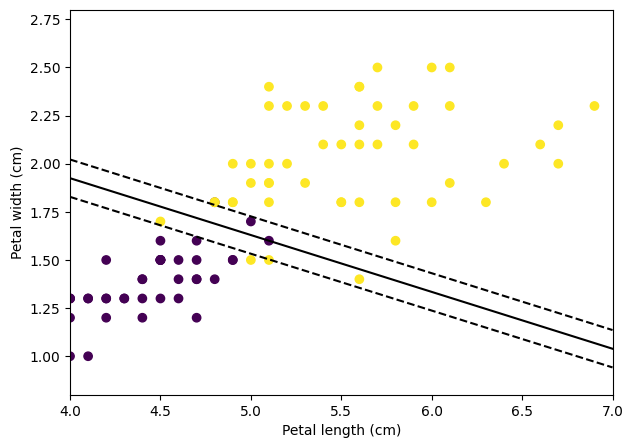

In [5]:
# Extract trained model and scaler
scaler = svm_clf.named_steps["scaler"]
linear_svc = svm_clf.named_steps["linear_svc"]

# Convert coef/intercept from scaled space to original space for plotting
w_scaled = linear_svc.coef_[0]
b_scaled = linear_svc.intercept_[0]
w = w_scaled / scaler.scale_
b = b_scaled - np.sum((scaler.mean_ / scaler.scale_) * w_scaled)

# Create a lightweight object with coef_/intercept_ for plotting
class _Lin:
    pass

lin_for_plot = _Lin()
lin_for_plot.coef_ = np.array([w])
lin_for_plot.intercept_ = np.array([b])

plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_svc_decision_boundary(lin_for_plot, xmin=4, xmax=7)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.xlim(4, 7)
plt.ylim(0.8, 2.8)
plt.show()

## 6) Soft Margin: Effect of C

We compare a small C vs a large C.
- Small C: more regularization, smoother boundary, potentially better generalization
- Large C: less regularization, tries to classify training points correctly (risk of overfitting)

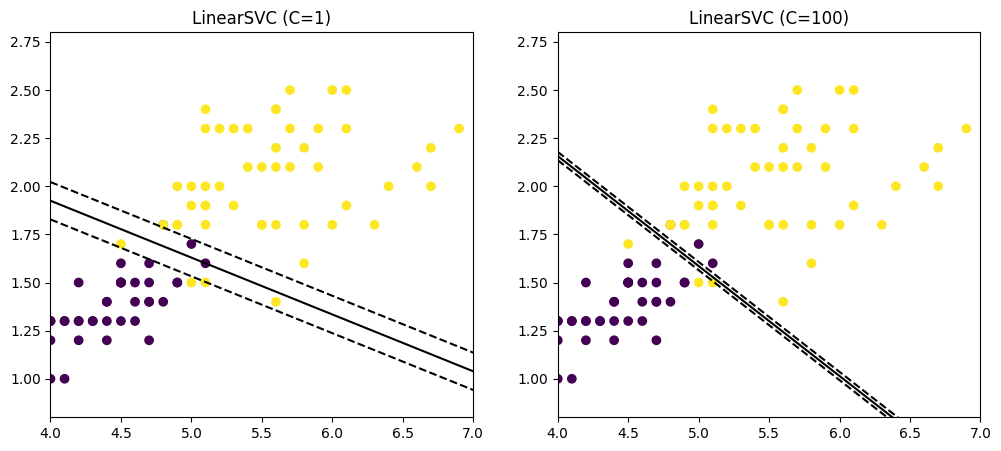

In [6]:
svm_clf_C1 = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42, max_iter=20000))
])

svm_clf_C100 = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=100, loss="hinge", random_state=42, max_iter=20000))
])

svm_clf_C1.fit(X, y)
svm_clf_C100.fit(X, y)

def get_unscaled_line(pipeline):
    scaler = pipeline.named_steps["scaler"]
    svc = pipeline.named_steps["linear_svc"]
    w_scaled = svc.coef_[0]
    b_scaled = svc.intercept_[0]
    w = w_scaled / scaler.scale_
    b = b_scaled - np.sum((scaler.mean_ / scaler.scale_) * w_scaled)
    lin = _Lin()
    lin.coef_ = np.array([w])
    lin.intercept_ = np.array([b])
    return lin

lin1 = get_unscaled_line(svm_clf_C1)
lin100 = get_unscaled_line(svm_clf_C100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_svc_decision_boundary(lin1, xmin=4, xmax=7)
plt.title("LinearSVC (C=1)")
plt.xlim(4, 7)
plt.ylim(0.8, 2.8)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_svc_decision_boundary(lin100, xmin=4, xmax=7)
plt.title("LinearSVC (C=100)")
plt.xlim(4, 7)
plt.ylim(0.8, 2.8)

plt.show()

# Part B — Nonlinear SVM

## 7) Nonlinear Data: make_moons

We create a classic nonlinear dataset.
Linear classifiers struggle here, so we need:
- polynomial features or
- kernels (poly / RBF)

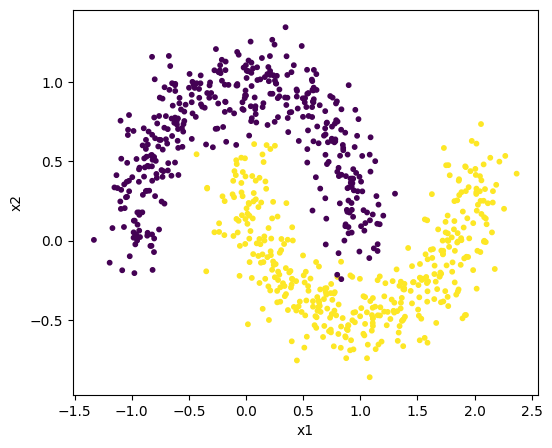

In [7]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=42)

plt.figure(figsize=(6, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## 8) Polynomial Features + Linear SVM

One approach is to manually add polynomial features and then apply a linear SVM.
This can capture nonlinear boundaries but may increase dimensionality quickly.

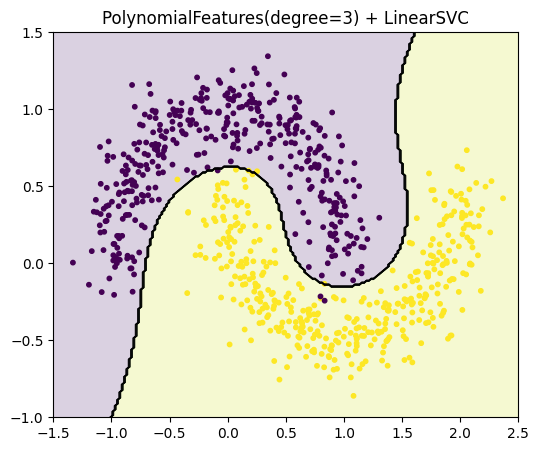

In [8]:
poly_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42, max_iter=20000))
])

poly_svm_clf.fit(X_train, y_train)

plt.figure(figsize=(6, 5))
plot_predictions(poly_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.title("PolynomialFeatures(degree=3) + LinearSVC")
plt.show()

## 9) Polynomial Kernel SVM (Kernel Trick)

Instead of explicitly computing polynomial features, the kernel trick computes
similarity in a higher-dimensional space implicitly.

Key hyperparameters:
- degree: polynomial degree
- coef0: controls influence of higher-order vs lower-order terms
- C: regularization

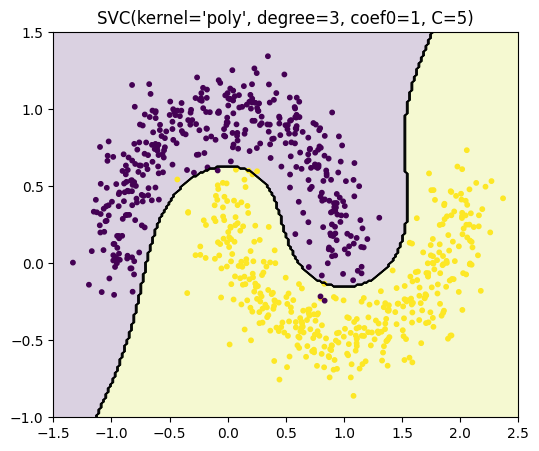

In [9]:
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X_train, y_train)

plt.figure(figsize=(6, 5))
plot_predictions(poly_kernel_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.title("SVC(kernel='poly', degree=3, coef0=1, C=5)")
plt.show()

## 10) RBF (Gaussian) Kernel SVM

RBF kernel is very popular and flexible.
Hyperparameters:
- gamma: how far the influence of a single training example reaches
  - small gamma -> smoother boundary (underfitting risk)
  - large gamma -> very complex boundary (overfitting risk)
- C: regularization (same role as before)

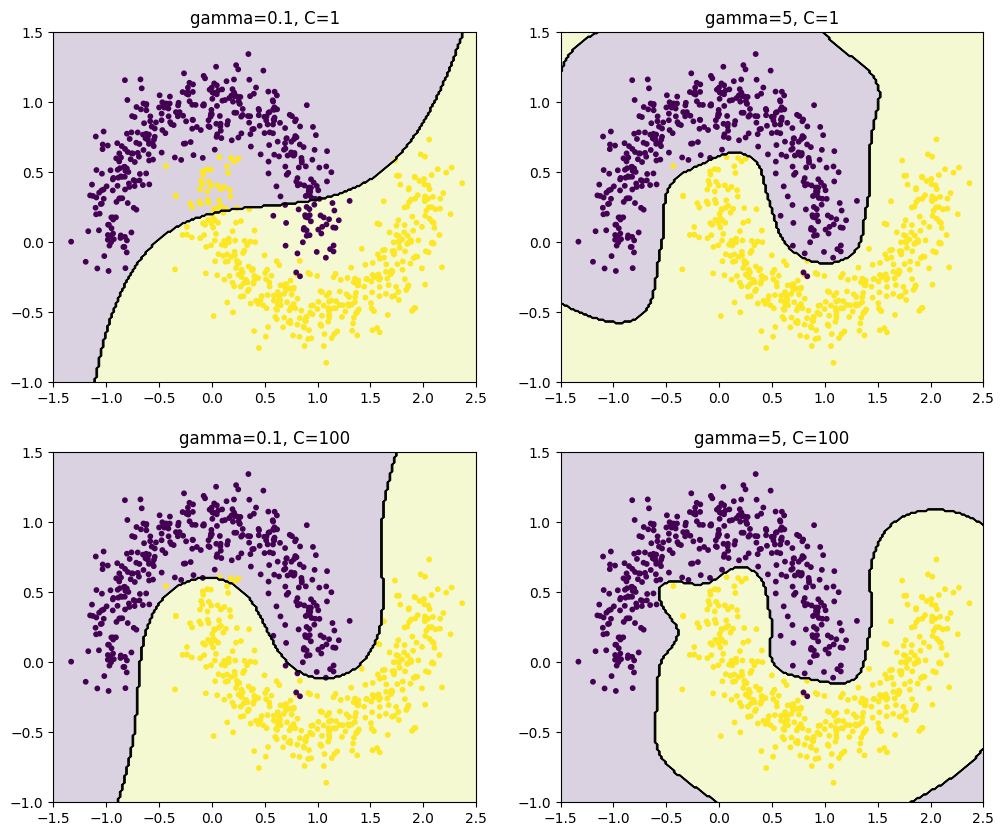

In [10]:
rbf1 = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", gamma=0.1, C=1))
])

rbf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", gamma=5, C=1))
])

rbf3 = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", gamma=0.1, C=100))
])

rbf4 = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", gamma=5, C=100))
])

models = [rbf1, rbf2, rbf3, rbf4]
titles = [
    "gamma=0.1, C=1",
    "gamma=5, C=1",
    "gamma=0.1, C=100",
    "gamma=5, C=100",
]

for m_ in models:
    m_.fit(X_train, y_train)

plt.figure(figsize=(12, 10))
for i, (m_, title) in enumerate(zip(models, titles), 1):
    plt.subplot(2, 2, i)
    plot_predictions(m_, axes=[-1.5, 2.5, -1, 1.5])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
    plt.title(title)
plt.show()

# Part C — SVM Regression

## 11) SVM Regression Intuition

SVM regression tries to fit as many instances as possible within an epsilon-wide tube.
- epsilon controls tube width (tolerance)
- C controls regularization (penalizes points outside tube)

We demonstrate LinearSVR and kernel SVR.

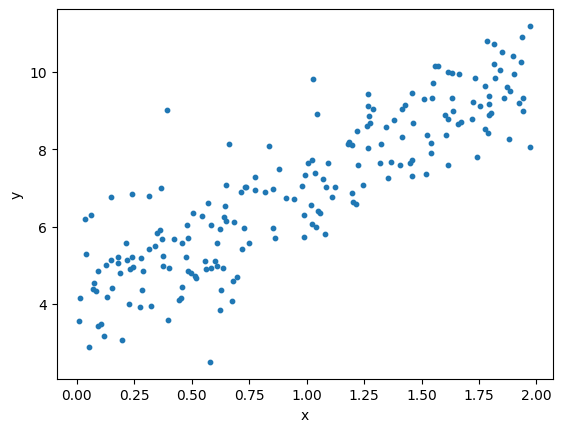

In [11]:
np.random.seed(42)
m = 200
X_reg = 2 * np.random.rand(m, 1)
y_reg = (4 + 3 * X_reg + np.random.randn(m, 1)).ravel()

plt.scatter(X_reg, y_reg, s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 12) LinearSVR
We fit a linear SVM regressor. Scaling is recommended.

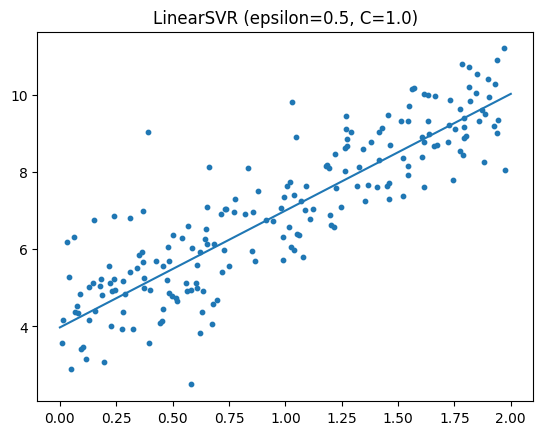

In [12]:
lin_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", LinearSVR(epsilon=0.5, C=1.0, random_state=42, max_iter=20000))
])

lin_svr.fit(X_reg, y_reg)

X_new = np.linspace(0, 2, 100).reshape(-1, 1)
y_pred = lin_svr.predict(X_new)

plt.scatter(X_reg, y_reg, s=10)
plt.plot(X_new, y_pred)
plt.title("LinearSVR (epsilon=0.5, C=1.0)")
plt.show()

## 13) SVR with RBF Kernel
Kernel SVR can model nonlinear relationships. We demonstrate the effect of gamma.

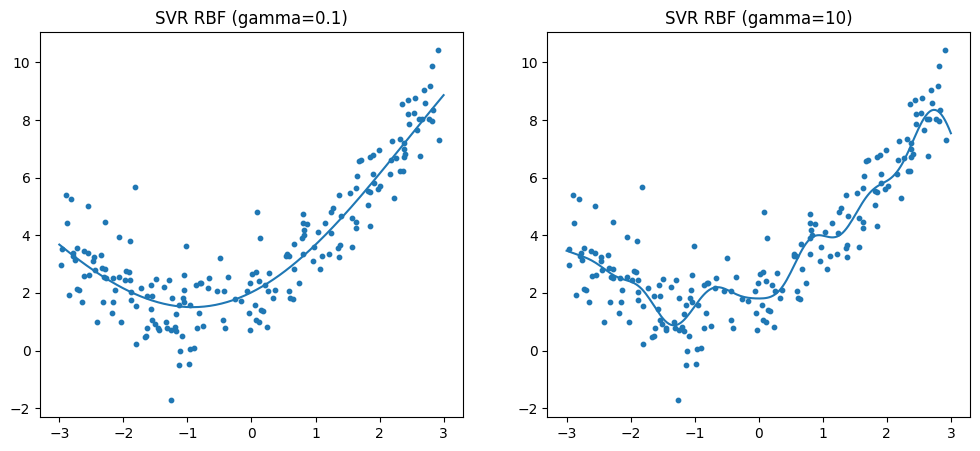

In [13]:
np.random.seed(42)
X_reg2 = 6 * np.random.rand(m, 1) - 3
y_reg2 = (0.5 * X_reg2**2 + X_reg2 + 2 + np.random.randn(m, 1)).ravel()

svr_rbf_small = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", gamma=0.1, C=10, epsilon=0.1))
])

svr_rbf_large = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", gamma=10, C=10, epsilon=0.1))
])

svr_rbf_small.fit(X_reg2, y_reg2)
svr_rbf_large.fit(X_reg2, y_reg2)

X_new = np.linspace(-3, 3, 200).reshape(-1, 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_reg2, y_reg2, s=10)
plt.plot(X_new, svr_rbf_small.predict(X_new))
plt.title("SVR RBF (gamma=0.1)")

plt.subplot(1, 2, 2)
plt.scatter(X_reg2, y_reg2, s=10)
plt.plot(X_new, svr_rbf_large.predict(X_new))
plt.title("SVR RBF (gamma=10)")

plt.show()

## 14) Takeaways
- Linear SVM aims for a large margin; only support vectors matter.
- Soft margin: `C` controls the trade-off between margin size and training errors.
- For nonlinear problems, use polynomial features or kernels (poly / RBF).
- RBF kernel: `gamma` controls flexibility; `C` controls regularization.
- SVM regression uses an epsilon-insensitive tube; `epsilon`, `C`, and kernel settings shape the fit.

## 15) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 5.
- scikit-learn documentation: `LinearSVC`, `SVC`, `LinearSVR`, `SVR`.